# Depresjon - basic feature engineering

This notebook aims to recreate feature engineering for Depresjon dataset from paper "Comparison of Night, Day and 24 h Motor Activity Data for the Classification of Depressive Episodes".

## Libraries

In [19]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

## Data loading

First, we have to load the data.

In [4]:
data_dir = "./depresjon_data"
condition_dir = os.path.join(data_dir, "condition")
control_dir = os.path.join(data_dir, "control")
scores_file = os.path.join(data_dir, "scores.csv")

`condition` and `control` directories contain CSV files with measurements, one file per person. For example, `condition_1.csv` contains measurements for patient 1 diagnosed with depression.

Those files are read into a list of dataframes, since this makes them easy to process later.

In [5]:
conditions = [pd.read_csv(os.path.join(condition_dir, filename)) for filename in os.listdir(condition_dir)]
controls = [pd.read_csv(os.path.join(control_dir, filename)) for filename in os.listdir(control_dir)]

In [7]:
conditions[0].head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


The `scores.csv` file contains static information about patients.

In [8]:
static_data = pd.read_csv(scores_file)
static_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


## Exploratory data analysis

We have the data loaded, now we can explore it: check number of measurements, number of columns, their types, missing values etc. First the data for time series will be checked, then for the static data.

### Number of patients

Condition number: 23
Control number: 32


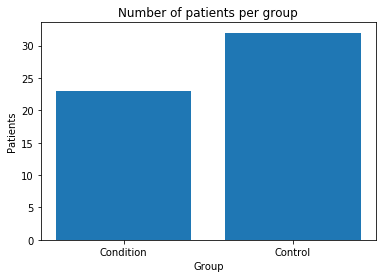

In [22]:
xs = ["Condition", "Control"]
ys = [len(conditions), len(controls)]

print(f"Condition number: {len(conditions)}")
print(f"Control number: {len(controls)}")

plt.bar(xs, ys)
plt.xlabel("Group")
plt.ylabel("Patients")
plt.title("Number of patients per group")
plt.show()

We definitely have quite heavy imbalance, the control group being about 50% larger than the condition group. This influences many metrics and should be taken into consideration.

### Measurements number

In [20]:
condition_rows = pd.Series([len(df) for df in conditions])
condition_rows.describe()

count       23.000000
mean     23987.652174
std       5748.966513
min      19299.000000
25%      21463.000000
50%      21648.000000
75%      23117.000000
max      41847.000000
dtype: float64

In [21]:
control_rows = pd.Series([len(df) for df in controls])
control_rows.describe()

count       32.000000
mean     31874.687500
std      12228.922745
min      20490.000000
25%      22258.500000
50%      28257.000000
75%      33683.000000
max      65407.000000
dtype: float64

We have greatly varying number of measurements for both condition and control group. In general measurements for control group are longer, but also more varied (both mean and standard deviation are higher). For fair assessment, where each patient gets the same chance to influence the model, the measurements should be of equal length for all cases. However, for calculating aggregations (e.g. mean / median value) this may not be necessary, since they typically reduce the data to a single number.

### Columns and types

In [9]:
conditions[0].head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [10]:
conditions[0].dtypes

timestamp    object
date         object
activity      int64
dtype: object

For measurement files we have 3 columns:
- timestamp with precise measurement date and time, with 1 minute measurement resolution
- date, information already included in the timestamp
- activity, the time series value

Data types of columns are definitely wrong - `timestamp` should be a proper timestamp and the `date` column is redundant. This will be fixed in the preprocessing section.

### Missing values

In [27]:
condition_NaNs = pd.Series([df["activity"].isna().sum() for df in conditions])
condition_NaNs.mean()

0.0

In [28]:
control_NaNs = pd.Series([df["activity"].isna().sum() for df in controls])
control_NaNs.mean()

0.0

We have exactly 0 missing values for the dependent variable, activity. This means that the data was accurately gathered for all patients for the entire duration of measurement period.

### Statis data

In [32]:
static_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [33]:
static_data.dtypes

number        object
days           int64
gender         int64
age           object
afftype      float64
melanch      float64
inpatient    float64
edu           object
marriage     float64
work         float64
madrs1       float64
madrs2       float64
dtype: object

In [34]:
for col in static_data.columns:
    print(col, static_data[col].unique())

number ['condition_1' 'condition_2' 'condition_3' 'condition_4' 'condition_5'
 'condition_6' 'condition_7' 'condition_8' 'condition_9' 'condition_10'
 'condition_11' 'condition_12' 'condition_13' 'condition_14'
 'condition_15' 'condition_16' 'condition_17' 'condition_18'
 'condition_19' 'condition_20' 'condition_21' 'condition_22'
 'condition_23' 'control_1' 'control_2' 'control_3' 'control_4'
 'control_5' 'control_6' 'control_7' 'control_8' 'control_9' 'control_10'
 'control_11' 'control_12' 'control_13' 'control_14' 'control_15'
 'control_16' 'control_17' 'control_18' 'control_19' 'control_20'
 'control_21' 'control_22' 'control_23' 'control_24' 'control_25'
 'control_26' 'control_27' 'control_28' 'control_29' 'control_30'
 'control_31' 'control_32']
days [11 18 13  7  5  9 14 12 16  8 20]
gender [2 1]
age ['35-39' '40-44' '45-49' '25-29' '50-54' '20-24' '60-64' '55-59' '30-34'
 '65-69']
afftype [ 2.  1.  3. nan]
melanch [ 2. nan  1.]
inpatient [ 2.  1. nan]
edu ['6-10' '11-15' '16-2

Observations:
- all data types seem correct
- `number` is essentially an index for patients and should not be used as a feature
- `days` indicate the number of data collection days, but this information is already included in the time series timestamps
- `gender` is correct, but doesn't follow the usual convention of 0-1 values for binary features
- `age` should be preprocessed to integers (e.g. `0` for <50 years, `1` for >= 50 years) for classification
- `afftype` and `melanch` indicate the clinical state observations for depressed patients and are NaN for non-depressed controls
- `edu`, `marriage` and `work` explain socioeconomic status of the patient
- `madrs1` and `madrs2` are MADRS score for patients with condition at the beginning and at the end of measurements; they are not used for classification, but they could be used as regression targets

## Feature engineering

In the paper several steps of feature engineering are introduced. They need to be performed, as the typical models for tabular data like Random Forest are used. This approach allows usage of classical ML algorithms on time series data, while also indirectly incorporating time dependencies in form of features derived from the signal.

### Preprocessing

First, trim the data to the same length as the shortest one. While this may sound extreme, we've seen before that mean number of measurements is about 24 thousand and 32 thousand for condition and control groups, while the minimal number is about 19 thousand and 20 thousand, respectively. Those are still very reasonably long signals to work with.

In [37]:
min_length = min([len(df) for df in conditions] + [len(df) for df in controls])

conditions_trimmed = [df.iloc[:min_length] for df in conditions]
controls_trimmed = [df.iloc[:min_length] for df in controls]

### Time domain

### Frequency domain

### Feature selection